In [2]:
from fastai.vision.widgets import *
from fastai.vision.utils import *
from fastai.imports import Path
from fastai.vision.core import *
import pandas as pd
from fastai.vision.data import DataBlock, DataLoaders, ImageDataLoaders
from fastai.vision.augment import *
from fastai.metrics import accuracy_multi, partial
from fastai.vision.models import resnet18
from fastai.interpret import ClassificationInterpretation
from fastai.vision.learner import cnn_learner
from fastai.callback.schedule import Learner

In [3]:
path = Path('gsc-images')

In [4]:
path.ls()

(#831) [Path('gsc-images/1-c.png'),Path('gsc-images/1-g.png'),Path('gsc-images/1-s.png'),Path('gsc-images/10-c.png'),Path('gsc-images/10-g.png'),Path('gsc-images/10-s.png'),Path('gsc-images/100-c.png'),Path('gsc-images/100-g.png'),Path('gsc-images/100-s.png'),Path('gsc-images/101-c.png')...]

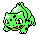

In [5]:
sprite = Image.open(path/'1-c.png')
sprite.to_thumb(128, 128)

In [6]:
csv_path = Path()
df = pd.read_csv(csv_path/'pokemon_ss_stripped_gsc.csv', delimiter=',')

df.head()

,Nat,Pokemon,Type
0,1-g,Bulbasaur,Grass Poison
1,2-g,Ivysaur,Grass Poison
2,3-g,Venusaur,Grass Poison
3,4-g,Charmander,Fire
4,5-g,Charmeleon,Fire


In [7]:
dls = ImageDataLoaders.from_csv(csv_path,
                               csv_fname='pokemon_ss_stripped_gsc.csv',
                               delimiter=',',
                               folder=path,
                               suff='.png',
                               valid_pct=0.2,
                               label_col=2,
                               label_delim=' ',
                               seed=42,
                               item_tfms=RandomResizedCrop(128, min_scale=0.35))

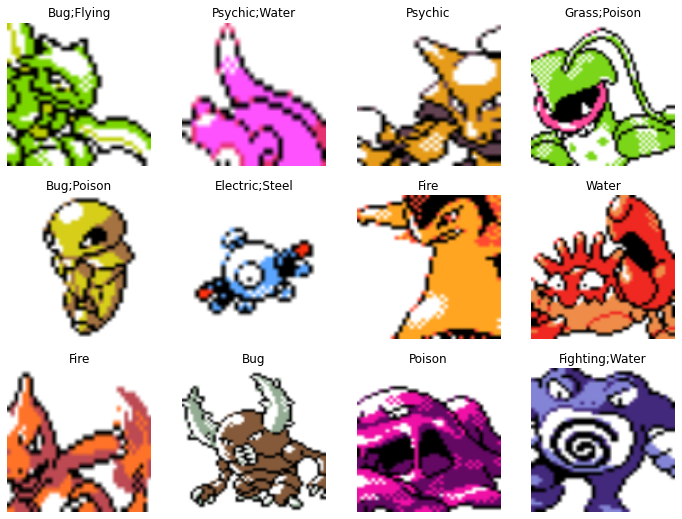

In [8]:
dls.show_batch(max_n=12, nrows=3)

In [9]:
acc = partial(accuracy_multi)

In [10]:
learn = cnn_learner(dls, resnet18, metrics=acc)

In [11]:
for item in learn.dls.vocab: print(item)

Bug
Dark
Dragon
Electric
Fighting
Fire
Flying
Ghost
Grass
Ground
Ice
Normal
Poison
Psychic
Rock
Steel
Water


In [12]:
learn.fine_tune(10)

(#5) [0,1.0291608572006226,0.8475894331932068,0.5329411625862122,'00:02']
(#5) [0,0.9540295004844666,0.7617487907409668,0.5407842993736267,'00:02']
(#5) [1,0.9372878074645996,0.7075423002243042,0.5772549510002136,'00:02']
(#5) [2,0.9197688102722168,0.6579459309577942,0.6188235282897949,'00:02']
(#5) [3,0.8863289952278137,0.6191733479499817,0.6572549343109131,'00:02']
(#5) [4,0.852446973323822,0.5915451049804688,0.6870588660240173,'00:02']
(#5) [5,0.8190303444862366,0.5667630434036255,0.7066666483879089,'00:02']
(#5) [6,0.7907577753067017,0.5452827215194702,0.7227451205253601,'00:02']
(#5) [7,0.7614431977272034,0.5296915769577026,0.7435293793678284,'00:02']
(#5) [8,0.7390137910842896,0.5195775032043457,0.7541176080703735,'00:02']
(#5) [9,0.7197252511978149,0.5212777853012085,0.7505882978439331,'00:02']


SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.019054606556892395)

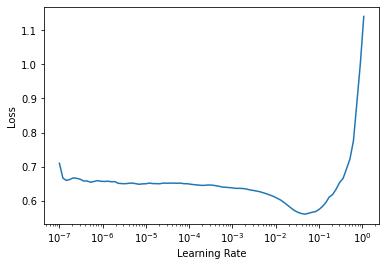

In [13]:
learn.lr_find()

In [14]:
# Ideal lr seems to be around 1e-2
learn_updated = cnn_learner(dls, resnet18, metrics=acc)

In [15]:
learn_updated.fine_tune(10, 1e-2)

(#5) [0,0.9747543334960938,0.8332030177116394,0.5772548913955688,'00:01']
(#5) [0,0.8036864399909973,0.6822474002838135,0.6337255239486694,'00:02']
(#5) [1,0.740776002407074,0.5444380640983582,0.7356863021850586,'00:02']
(#5) [2,0.6526042819023132,0.3621804714202881,0.8580392599105835,'00:02']
(#5) [3,0.5468159317970276,0.200542151927948,0.932941198348999,'00:02']
(#5) [4,0.4556872844696045,0.19023682177066803,0.9372549653053284,'00:02']
(#5) [5,0.3808744549751282,0.13578948378562927,0.9505882859230042,'00:02']
(#5) [6,0.32207754254341125,0.1258903294801712,0.9568626880645752,'00:02']
(#5) [7,0.27698877453804016,0.11653117835521698,0.9592157006263733,'00:02']
(#5) [8,0.24167825281620026,0.11281769722700119,0.9596078395843506,'00:02']
(#5) [9,0.21272364258766174,0.11154638975858688,0.9599999785423279,'00:02']


In [16]:
interp = ClassificationInterpretation.from_learner(learn_updated)

,target,predicted,probabilities,loss
0,Dark;Ice,Poison,"tensor([2.4851e-03, 3.6310e-02, 8.7008e-03, 1.0726e-02, 5.6092e-03, 7.7004e-04,\n 5.4870e-02, 1.5554e-01, 3.7951e-02, 1.4369e-02, 2.4035e-03, 2.1575e-03,\n 9.5670e-01, 9.2889e-03, 4.8116e-03, 2.4836e-02, 3.1166e-02])",0.7568421959877014
1,Ice;Water,Poison,"tensor([0.0768, 0.0119, 0.0093, 0.0114, 0.0146, 0.0112, 0.0169, 0.0346, 0.0189,\n 0.0701, 0.0119, 0.0227, 0.5867, 0.1915, 0.0564, 0.0454, 0.0744])",0.5020895600318909
2,Flying;Ground,Psychic,"tensor([0.0222, 0.0111, 0.0176, 0.0239, 0.0359, 0.0130, 0.0621, 0.0157, 0.0194,\n 0.0132, 0.0196, 0.1044, 0.0805, 0.6012, 0.0103, 0.0374, 0.0498])",0.5002215504646301
3,Flying;Ground,Psychic,"tensor([0.0151, 0.0176, 0.0164, 0.0413, 0.0180, 0.0306, 0.0365, 0.0192, 0.0150,\n 0.0456, 0.0105, 0.0668, 0.1334, 0.5223, 0.0208, 0.0147, 0.1051])",0.4518682062625885
4,Normal,,"tensor([0.0141, 0.0109, 0.0101, 0.0175, 0.1009, 0.0102, 0.0173, 0.0039, 0.0369,\n 0.1303, 0.0057, 0.0057, 0.0024, 0.0479, 0.2477, 0.0270, 0.0076])",0.34825363755226135
5,Ground;Poison,Water,"tensor([0.0037, 0.0072, 0.0395, 0.0055, 0.0135, 0.0060, 0.0064, 0.0082, 0.0072,\n 0.1242, 0.0810, 0.0018, 0.1163, 0.0125, 0.0170, 0.0244, 0.7397])",0.34244832396507263
6,Normal,,"tensor([0.0140, 0.0065, 0.0143, 0.0151, 0.2320, 0.0081, 0.0032, 0.0045, 0.0114,\n 0.3585, 0.0063, 0.0115, 0.0012, 0.0303, 0.3302, 0.0389, 0.0046])",0.33713555335998535
7,Ice;Water,Water,"tensor([0.0571, 0.0056, 0.0156, 0.0043, 0.0263, 0.0257, 0.0031, 0.0042, 0.0186,\n 0.1775, 0.0241, 0.0039, 0.0227, 0.0702, 0.2641, 0.0465, 0.5155])",0.30588072538375854
8,Bug;Poison,,"tensor([0.2437, 0.0061, 0.0148, 0.1235, 0.0111, 0.0094, 0.0280, 0.0091, 0.0881,\n 0.0167, 0.0082, 0.0357, 0.0350, 0.0229, 0.0066, 0.0158, 0.0098])",0.30501237511634827
9,Normal;Psychic,Fire;Normal,"tensor([0.0027, 0.0664, 0.0128, 0.0244, 0.0065, 0.7782, 0.0452, 0.0084, 0.0015,\n 0.0014, 0.0029, 0.6191, 0.0017, 0.0510, 0.0023, 0.0032, 0.0117])",0.30334165692329407


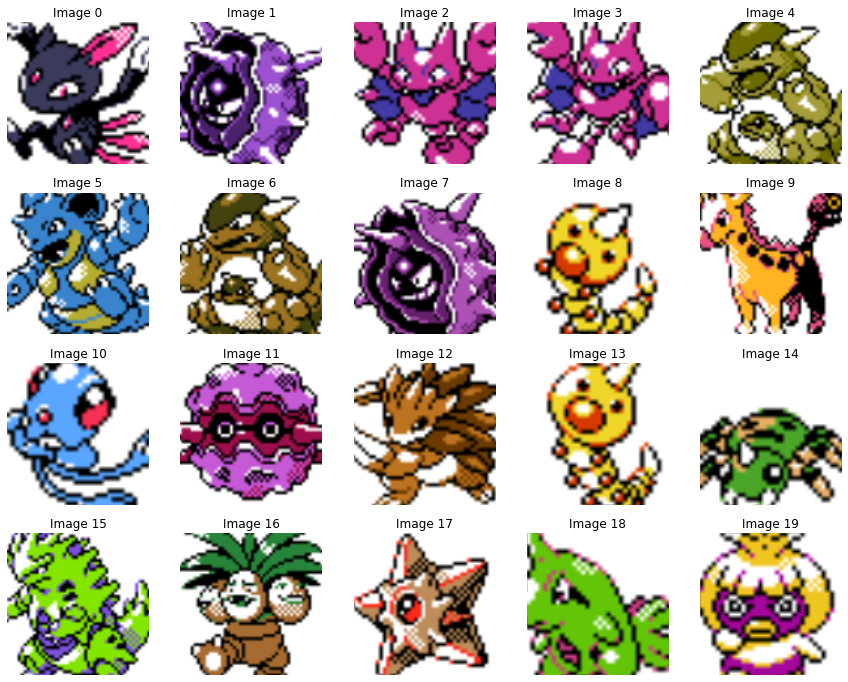

In [17]:
interp.plot_top_losses(20)

In [18]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [38]:
pred,pred_idx,probs = learn_updated.predict(img)

In [39]:
pred
probs

tensor([0.0127, 0.0086, 0.0168, 0.0224, 0.0173, 0.5826, 0.0649, 0.0041, 0.0648,
        0.0130, 0.0368, 0.0704, 0.0050, 0.0229, 0.0030, 0.0056, 0.0043])

In [40]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probabilities: {probs[pred_idx].numpy()}'
lbl_pred

Label(value="Prediction: (#1) ['Fire']; Probabilities: [0.582642]")

In [43]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [41]:
btn_upload = widgets.FileUpload()

In [44]:
#hide_output
VBox([widgets.Label('Choose your pokemon!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [48]:
learn_updated.export()